In [1]:
!pip install catboost
!pip install scikit-learn --upgrade

     |████████████████████████████████| 65.7MB 46kB/s 
     |████████████████████████████████| 22.3MB 1.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import catboost as cats # graident boosting 

from catboost import CatBoostRegressor, Pool

import datetime
import numpy as np  # math and stuff
import matplotlib.pyplot as plt # plotting utility
import sklearn # ML and stats

print('catboost ver:', cats.__version__)
print('scikit ver:', sklearn.__version__)

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import max_error, mean_squared_error, median_absolute_error

catboost ver: 0.24.4
scikit ver: 0.24.1


In [3]:
# df2 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/offset_test_imputed_2_27_2021.csv')
df= pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS1_offset_imputed_3_1_2021.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.471137,0.327849,0.434758,0.811507,0.616131,0.354609,0.983795,0.168718,0.168718,0.354524,0.327861,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.188826,0.239096,0.264250,0.161929,0.214640,0.186733,1.492375,0.223023,0.223023,0.177861,0.231827,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.869262,0.000712,0.000712,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.363563,0.123421,0.180440,0.742248,0.430126,0.220840,-0.072751,0.004595,0.004595,0.227592,0.133010,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.558228,0.276630,0.508127,0.866696,0.607417,0.334901,0.779512,0.005532,0.005532,0.342525,0.282723,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602712,0.537205,0.664217,0.925012,0.831579,0.472719,1.377057,0.328428,0.328428,0.467496,0.530003,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

# Split F028

In [5]:
df_F028 = df[df['USGS_ID']=='F042']
df = df[df['USGS_ID']!='F042']
df

,depth_ft,USGS_ID,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,sample,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
0,7741.0,F028,0.656743,0.277148,0.048798,0.640470,0.860321,0.392095,0.429013,0.001416,0.001416,0.366586,0.231845,4.0313,4.0320,NaN,NaN,NaN,NaN,NaN,14.5,5.55,1500675-Mudrock Dual,1.2770,0.0263,0.6987,0.0116,2.8101,0.0112,33.9921,0.0332,0.0826,0.0021,0.1116,0.0011,0.9947,0.0045,4.5640,0.0073,0.1641,0.0013,0.0085,0.0001,0.0186,0.0008,1.4531,0.0029,0.0011,0.0,0.0044,0.0001,0.0,0.0008,0.0023,0.0008,0.0663,0.0049
1,7741.1,F028,0.656317,0.282290,0.042615,0.640427,0.859502,0.379727,0.382075,0.001404,0.001404,0.365602,0.233654,3.9834,3.9834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7741.2,F028,0.655891,0.283598,0.046899,0.640489,0.858582,0.368137,0.336591,0.001385,0.001385,0.365408,0.235172,3.9837,3.9836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7741.3,F028,0.655465,0.284300,0.052055,0.640491,0.857807,0.356390,0.292516,0.001377,0.001377,0.366405,0.236318,3.9840,3.9840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7741.4,F028,0.655039,0.285118,0.054869,0.640371,0.856756,0.343881,0.243735,0.001438,0.001438,0.368492,0.237060,3.9843,3.9843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12025,13378.0,PDRMT,0.079293,0.402299,0.405779,0.403408,0.334581,0.839292,0.359922,0.659317,0.659317,0.332308,0.405787,4.3717,4.3658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500503-Mudrock Dual,0.5632,0.0196,0.5084,0.0102,1.8027,0.0094,35.4358,0.0311,0.1020,0.0024,0.2357,0.0015,0.5846,0.0034,4.3886,0.0066,0.1207,0.0012,0.0114,0.0002,0.0153,0.0007,1.0049,0.0024,0.0008,0.0,0.0049,0.0001,0.0,0.0007,0.0034,0.0008,0.1478,0.0056
12026,13378.1,PDRMT,0.079191,0.403411,0.406010,0.404965,0.330337,0.758978,0.420557,0.672716,0.672716,0.336142,0.408253,6.6922,6.7092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12027,13378.2,PDRMT,0.079089,0.404386,0.406225,0.405379,0.324857,0.675050,0.454497,0.676108,0.676108,0.339824,0.410564,6.7190,6.7313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12028,13378.3,PDRMT,0.078987,0.405216,0.406441,0.401656,0.319678,0.578939,0.488671,0.681536,0.681536,0.343348,0.412729,4.3369,4.3273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dataset = df[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

dataset.replace('NaN',np.nan, regex=True, inplace=True)# Should be good already
# dataset = dataset.dropna() # not needed

dataset.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,gz_pchip_interp
0,0.656743,0.277148,0.048798,0.640470,0.860321,0.392095,0.429013,0.001416,0.001416,0.231845,0.366586,4.0320
1,0.656317,0.282290,0.042615,0.640427,0.859502,0.379727,0.382075,0.001404,0.001404,0.233654,0.365602,3.9834
2,0.655891,0.283598,0.046899,0.640489,0.858582,0.368137,0.336591,0.001385,0.001385,0.235172,0.365408,3.9836


In [7]:
# Features we will use for prediction
X = dataset[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y = dataset[['gz_pchip_interp']]

Y_array = np.array(Y.values)

In [8]:
seed = 42 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

In [9]:
preds = 0
preds2 = 0

export_name = 'test_test_test.csv'
max_iter=500

# def catboost_gz(X_train, X_test, y_train, y_test, export_name, max_iter=500):

model = CatBoostRegressor(objective='RMSE',
                            task_type='GPU',
                            iterations=max_iter)
  
model.fit(X_train, y_train, verbose=1000 )
preds = model.predict(X_test)

  # Stats
rmse = mean_squared_error(y_test, preds, squared=False)
print("Root Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))
MAE= median_absolute_error(y_test, preds)
print("Median Abs Error: %f" % (max))

  # Let's Tune
grid = {'learning_rate': [0.1, 0.2, 0.4],
        'depth': [6, 8, 10,  12, 14],
        'l2_leaf_reg': [2, 3, 4 , 5, 6 ]}

model_grid = CatBoostRegressor(objective='RMSE',
                                 task_type='GPU',
                                 iterations=max_iter)

  # Grid Search
grid_search_result = model_grid.grid_search(grid, 
                                            X=X_train, 
                                            y=y_train, 
                                            cv=5,
                                            verbose=False)
model2 = CatBoostRegressor(objective='RMSE',
                           depth=grid_search_result['params']['depth'],
                           l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
                           learning_rate=grid_search_result['params']['learning_rate'],
                           iterations=max_iter)

model2.fit(X_train, y_train, verbose=500)
preds2 = model2.predict(X_test)

# Stats for the second round
rmse2 = mean_squared_error(y_test, preds2, squared=False)
print("Root Mean Squared Error: %f" % (rmse2))
max2 = max_error(y_test, preds2)
print("Max Error: %f" % (max2))
MAE2= median_absolute_error(y_test, preds2)
print("Median Abs Error: %f" % (MAE2))

x = datetime.datetime.now()

d = {'target': [Y.columns.values, Y.columns.values],
     'MSE': [rmse, rmse2],
     'MAE': [MAE, MAE2],
     'MaxError': [max, max2], 
     'iter': [max_iter, max_iter],
     'day': [x.day, x.day], 
     'month':[x.month, x.month], 
     'year':[x.year, x.year],
     'model':['catboost', 'catboost'],
     'version':[cats.__version__, cats.__version__ ]}

results = pd.DataFrame(data=d)

filepath = 'drive/My Drive/1_lewis_research/analysis/experiments/catboost/catboost_results/'
#results.to_csv(filepath+export_name)

 # return results

Learning rate set to 0.110871
0:	learn: 1.6834710	total: 11ms	remaining: 5.51s
499:	learn: 1.1839239	total: 3.08s	remaining: 0us
Root Mean Squared Error: 1.198153
Max Error: 4.526762
Median Abs Error: 4.526762
bestTest = 0.865578821
bestIteration = 499
bestTest = 0.8519031605
bestIteration = 463
bestTest = 0.7920875979
bestIteration = 495
bestTest = 0.8860847645
bestIteration = 493
bestTest = 0.8281492474
bestIteration = 499
bestTest = 0.7812542529
bestIteration = 496
bestTest = 0.8814281394
bestIteration = 499
bestTest = 0.8322974514
bestIteration = 499
bestTest = 0.8027336861
bestIteration = 499
bestTest = 0.88282825
bestIteration = 499
bestTest = 0.8344458623
bestIteration = 499
bestTest = 0.7982371936
bestIteration = 499
bestTest = 0.8985623064
bestIteration = 499
bestTest = 0.8517551506
bestIteration = 499
bestTest = 0.7991879286
bestIteration = 499
bestTest = 0.854041241
bestIteration = 499
bestTest = 0.79379417
bestIteration = 499
bestTest = 0.7885801645
bestIteration = 479
best

In [29]:
grid_search_result['params']['depth']

14

In [10]:
results

,target,MSE,MAE,MaxError,iter,day,month,year,model,version
0,[gz_pchip_interp],1.198153,0.797784,4.526762,500,9,3,2021,catboost,0.24.4
1,[gz_pchip_interp],0.671477,0.141094,4.019085,500,9,3,2021,catboost,0.24.4


# Now Run it on F028

In [11]:
dataset2 = df_F028[[
    'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
    'RESD', 'PHIN', 'PHID', 'GR_smooth', 
    'PE_smooth',
    'gz_pchip_interp' # Trying to predict gz_pchip_interp
]]

dataset2.replace('NaN',np.nan, regex=True, inplace=True)# Should be good already
# dataset = dataset.dropna() # not needed

dataset2.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,gz_pchip_interp
3577,0.245564,0.0,0.180675,0.833846,0.920354,0.178352,0.154482,0.190525,0.190525,0.003813,0.164032,4.0398
3578,0.245565,0.0,0.178683,0.834179,0.921601,0.169993,0.142223,0.185127,0.185127,0.003241,0.157714,4.0398
3579,0.245558,0.0,0.176691,0.834502,0.920621,0.161763,0.130035,0.184832,0.184832,0.002899,0.151542,4.0398


In [12]:
# Features we will use for prediction
X2 = dataset2[['CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

# What we are trying to predict
Y2 = dataset2[['gz_pchip_interp']]

Y2_array = np.array(Y2.values)

In [13]:
preds3 = model2.predict(X2)
preds3

array([4.93325506, 4.8716447 , 4.84090129, 4.99635571, 5.11164328,
       5.11273358, 5.1811314 , 5.20911038, 5.23223369, 5.16863462,
       5.35427968, 5.16120614, 4.81618454, 4.80981125, 4.50987463,
       4.36614353, 4.33810675, 3.6852353 , 3.93085044, 4.1698607 ,
       4.14815875, 4.10756077, 4.13165329, 4.13672299, 4.09274673,
       4.12610754, 4.10582883, 4.10650129, 3.57691645, 3.56680938,
       3.50226008, 3.49918853, 3.47097134, 3.49393351, 3.53367832,
       3.53063811, 3.66484181, 3.85042372, 3.89897208, 3.88254408,
       3.90566232, 3.91434097, 4.53147537, 4.36514365, 4.30655272,
       4.10357093, 4.10395668, 3.40423102, 3.37533485, 3.46891893,
       3.31322692, 3.27043955, 3.29319068, 3.29466301, 3.2680935 ,
       3.21180296, 3.22672863, 3.22035235, 3.21001279, 3.67789041,
       3.70562796, 3.7006084 , 3.80776269, 3.80776269, 3.8022779 ,
       3.78815342, 3.78815342, 3.78815342, 3.7939856 , 3.79396187,
       3.79396187, 3.78953366, 3.86114333, 3.89753109, 3.90638

In [14]:
# Stats for the second round
rmse2 = mean_squared_error(Y2_array, preds3, squared=False)
print("Root Mean Squared Error: %f" % (rmse2))
max2 = max_error(Y2_array, preds3)
print("Max Error: %f" % (max2))
MAE2= median_absolute_error(Y2_array, preds3)
print("Median Abs Error: %f" % (MAE2))

Root Mean Squared Error: 0.640676
Max Error: 2.760179
Median Abs Error: 0.240295


In [15]:
Y2.gz_pchip_interp

3577    4.0398
3578    4.0398
3579    4.0398
3580    4.0398
3581    4.0398
         ...  
4337    6.1192
4338    3.8266
4339    3.9411
4340    6.8586
4341    4.9505
Name: gz_pchip_interp, Length: 765, dtype: float64

In [16]:
np.shape(Y2.gz_pchip_interp.values)

(765,)

In [17]:
np.shape(preds3[:])

(765,)

In [18]:
smooth_window = np.ones(7)/7

In [19]:
np.convolve(smooth_window, preds3, mode='same')

array([2.80602239, 3.53625715, 4.26664766, 5.00680929, 5.04621719,
       5.0977299 , 5.14454895, 5.19568095, 5.20276135, 5.16039721,
       5.10735147, 5.00746065, 4.88373348, 4.76508665, 4.52665173,
       4.35088663, 4.25855466, 4.16403287, 4.10655946, 4.07306086,
       4.04429175, 4.10250767, 4.13040154, 4.12125413, 4.11530306,
       4.03949673, 3.95880474, 3.86816718, 3.78337316, 3.68978227,
       3.60236865, 3.5205368 , 3.51392561, 3.52793024, 3.5776679 ,
       3.63477984, 3.69357595, 3.75239435, 3.80677473, 3.94975148,
       4.0497946 , 4.11495588, 4.14418429, 4.17581466, 4.10418162,
       4.02718074, 3.87538697, 3.72511315, 3.57709698, 3.46132837,
       3.34571499, 3.32626678, 3.30290508, 3.26830646, 3.25503867,
       3.24640628, 3.30136338, 3.36007266, 3.4218605 , 3.5069976 ,
       3.59000247, 3.67313469, 3.75572621, 3.77147807, 3.78326742,
       3.79660702, 3.79463548, 3.79266393, 3.79084333, 3.80127045,
       3.81689583, 3.83378563, 3.84996221, 3.86614217, 3.88468

In [20]:
window = 3
smooth_window = np.ones(window)/window

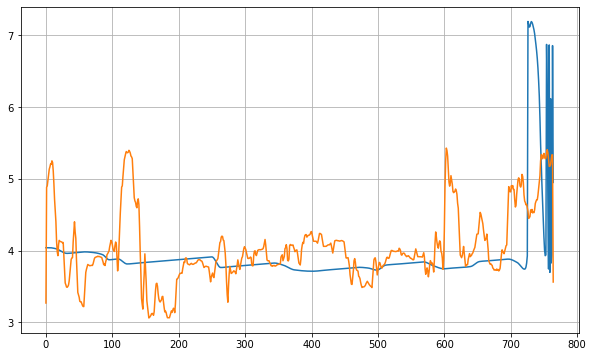

In [21]:
plt.figure(figsize=(10,6))
plt.plot(Y2.gz_pchip_interp.values)
#plt.plot(preds3)
plt.plot(np.convolve(smooth_window, preds3, mode='same'))
#plt.plot(np.convolve(smooth_window, Y2.gz_pchip_interp.values, mode='same'))
plt.grid(True)


In [22]:
yo = (preds3 - preds.min())/preds3.max()
mo = ((Y2 - Y2.min())/Y2.max())

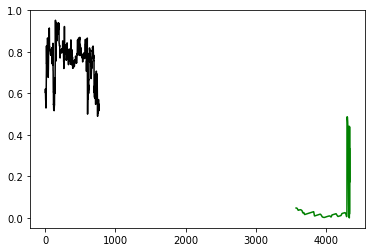

In [23]:
plt.plot(1-yo, color='black')
plt.plot(mo, color='g')

In [24]:
yo-mo.T

,3577,3578,3579,3580,3581,3582,3583,3584,3585,3586,3587,3588,3589,3590,3591,3592,3593,3594,3595,3596,3597,3598,3599,3600,3601,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611,3612,3613,3614,3615,3616,...,4302,4303,4304,4305,4306,4307,4308,4309,4310,4311,4312,4313,4314,4315,4316,4317,4318,4319,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337,4338,4339,4340,4341
gz_pchip_interp,0.346931,0.335883,0.330369,0.358247,0.378922,0.379118,0.391397,0.396484,0.400742,0.389504,0.42299,0.388602,0.326979,0.3261,0.272576,0.247079,0.242426,0.125832,0.170448,0.21395,0.210753,0.204209,0.209293,0.210953,0.203817,0.210509,0.207539,0.208243,0.113786,0.112377,0.101093,0.100695,0.095648,0.099725,0.106797,0.106182,0.130138,0.163307,0.171888,0.168803,...,0.313882,-0.171661,-0.163625,-0.18313,-0.157076,-0.156536,-0.144248,-0.18138,-0.135756,-0.159978,-0.158119,-0.124166,-0.115135,-0.081739,-0.075162,-0.065396,-0.036527,0.016265,0.055612,0.103171,0.193027,0.303589,0.280884,0.30117,0.378413,0.399422,0.417791,0.422443,0.422412,0.023244,0.15954,0.348542,0.436303,0.000651,0.429381,0.107659,0.434917,0.430025,0.044021,0.278072


In [25]:
ted = (preds3 - Y2_array.T)